1. Instalación y Carga de Librerías
Este bloque debe ir al inicio de tu nuevo notebook.

## Fine-tuning del modelo BETO para clasificación retórica

Objetivo:
Ajustar el modelo de lenguaje BETO (BERT para español) a la tarea de clasificación de las cuatro categorías retóricas.

In [6]:
# Instalación (si la necesitas en un entorno nuevo)
!pip install -U datasets transformers accelerate scikit-learn numpy pandas

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score


2. Carga y Preparación Inicial de Datos (Del Notebook 1)
Aquí cargamos tu archivo CSV y separamos la columna de texto y las etiquetas.

In [7]:
# === BLOQUE DE PREPARACIÓN DE DATOS CORREGIDO EN CELDA [2] ===

# 1. Definición de nombres de columna (Corregido a 'labels')
COLUMNA_TEXTO_REAL = 'text' # Coincide con tu archivo
COLUMNA_ETIQUETA_REAL = 'labels' # ESTA ES LA CORRECCIÓN: usamos 'labels'

# 2. Carga del archivo (Usando la ruta que ya funciona: ../data/...)
RUTA_ARCHIVO = '../data/processed/clean_v2/corpus_politico_codificado_utf8_clean_v2_shuffled.csv'

try:
    df = pd.read_csv(RUTA_ARCHIVO) 
except FileNotFoundError:
    print(f"ERROR CRÍTICO: No se encuentra el archivo en la ruta: {RUTA_ARCHIVO}. Verifica la ruta.")

# 3. RENOMBRAR LAS COLUMNAS al formato esperado por el modelo (text y label)
# Ahora renombramos 'labels' a 'label'
df.rename(columns={COLUMNA_TEXTO_REAL: 'text',
                   COLUMNA_ETIQUETA_REAL: 'label'}, inplace=True) 

# 4. Selección, Conversión y Limpieza
df = df[['text', 'label']] # Esto ahora funcionará
df['label'] = df['label'].astype(int) 
df = df.dropna()

# >>>>> NUEVA LÍNEA CRÍTICA PARA ELIMINAR LA FUGA DE DATOS <<<<<<<
df = df.reset_index(drop=True)

df_full = df.copy()

Celda [3]: Función de Partición (K-Fold Estratificado)
Esta celda define cómo se dividen los datos y aplica la división al DataFrame df_full

In [8]:
### CÓDIGO DE LA CELDA [3] ###
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Partición K-Fold con 5 splits
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Añadimos la columna 'fold' a df_full
df_full['fold'] = -1

# Aplicamos K-Fold
for fold, (train_index, test_index) in enumerate(skf.split(df_full['text'], df_full['label'])):
    df_full.loc[test_index, 'fold'] = fold
    
print(f"Dataset particionado en {N_SPLITS} folds.")
# df_full ahora contiene la columna 'fold' (0 a 4)

Dataset particionado en 5 folds.


Celda [4]: Tokenización y Función de Métricas
Esta celda prepara el tokenizer y la función que el Trainer usará para calcular la métrica F1-Macro (que es lo que quieres para clasificación multiclase).

In [9]:
### CÓDIGO DE LA CELDA [4] ###
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
NUM_LABELS = df_full['label'].nunique() 

def tokenize_function(examples):
    # Función que tokeniza las entradas de texto
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

def compute_metrics(p):
    # Función para Trainer: Calcula F1-Macro y Accuracy
    preds = np.argmax(p.predictions, axis=1)
    f1_macro = f1_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1_macro': f1_macro}

print("Tokenizer y funciones de métricas cargadas.")

Tokenizer y funciones de métricas cargadas.


Celda [5]: Ciclo de Entrenamiento BETO (Un Solo Fold)
Aquí definimos el modelo, los argumentos del entrenamiento y ejecutamos el finetuning. Por simplicidad y para la tesis, entrenaremos solo el Fold 0 y evaluaremos en el Fold 4 (Holdout).

In [10]:
### CÓDIGO DE LA CELDA [5] ###
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

TRAIN_FOLD = 0 # Fold usado para entrenar
TEST_FOLD = 4  # Fold usado como Holdout de prueba (el que nos dio problemas)

# 1. Separación de datos: Entrenamiento (Folds 0, 1, 2, 3) y Validación (Fold 4)
df_train = df_full[df_full['fold'] != TEST_FOLD]
df_test = df_full[df_full['fold'] == TEST_FOLD] # ESTA DATA SERÁ RE-UTILIZADA EN LA EVALUACIÓN

# 2. Conversión a formato Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train).remove_columns(['__index_level_0__', 'fold'])
test_dataset = Dataset.from_pandas(df_test).remove_columns(['__index_level_0__', 'fold'])

# 3. Tokenización
tokenized_train_data = train_dataset.map(tokenize_function, batched=True)
tokenized_test_data = test_dataset.map(tokenize_function, batched=True)

# 4. Creación del DatasetDict (Necesario para el Trainer)
tokenized_datasets = DatasetDict({
    'train': tokenized_train_data,
    'test': tokenized_test_data 
})

# 5. Configuración del Trainer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

training_args = TrainingArguments(
    output_dir=f'./results_fold_{TRAIN_FOLD}',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./logs_fold_{TRAIN_FOLD}',
    logging_steps=50,
    save_strategy="epoch",
    # Desactivamos la evaluación automática para evitar fugas de datos tempranas
    evaluation_strategy="no", 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    compute_metrics=compute_metrics,
)

# INICIAR ENTRENAMIENTO
print(f"\n--- Iniciando Finetuning en FOLD {TRAIN_FOLD} ({3} Épocas) ---")
trainer.train()
print("\n--- ¡ENTRENAMIENTO FINALIZADO! ---")

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Iniciando Finetuning en FOLD 0 (3 Épocas) ---


  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 1.2632, 'learning_rate': 5e-06, 'epoch': 1.0}
{'loss': 0.4031, 'learning_rate': 1e-05, 'epoch': 2.0}
{'loss': 0.0305, 'learning_rate': 1.5e-05, 'epoch': 3.0}
{'train_runtime': 74.9403, 'train_samples_per_second': 31.745, 'train_steps_per_second': 2.002, 'train_loss': 0.5655968062082927, 'epoch': 3.0}

--- ¡ENTRENAMIENTO FINALIZADO! ---


In [17]:
print("Columnas de df_train:")
print(df_train.columns.tolist())

print("\nPrimeras filas de df_train:")
df_train.head()


Columnas de df_train:
['text', 'label', 'fold']

Primeras filas de df_train:


,text,label,fold
0,Habla de verdad y solo cuenta su parte,0,2
1,La fuerza del pueblo es más fuerte que cualqui...,3,1
2,Más del 60 % de los empleos creados en pandemi...,2,0
3,No hay fuerza más grande que la esperanza,3,1
4,Se llena la boca de patria y vacía los bolsill...,0,0


## VALIDACION ADICIONAL DE FUGAS

In [22]:
# --- Chequeo de fugas entre TRAIN y TEST (Fold 4) ---

# 1) Si existe una columna de grupo, la usamos. Si no, lo saltamos.
group_col = None
for cand in ["group_id", "group", "grupo"]:
    if cand in df_train.columns and cand in df_test.columns:
        group_col = cand
        break

if group_col is not None:
    set_train_groups = set(df_train[group_col])
    set_test_groups  = set(df_test[group_col])

    inter_grupos = set_train_groups.intersection(set_test_groups)

    print(f"Columna de grupo detectada: '{group_col}'")
    print("N° de group_id en común entre train y test:", len(inter_grupos))
    if len(inter_grupos) > 0:
        print("Ejemplos de group_id compartidos:", list(inter_grupos)[:10])
else:
    print("⚠ No se encontró columna de grupo (group_id/group/grupo).")
    print("   No se puede comprobar fuga por grupos en este notebook.")
    
# 2) Revisar si hay textos exactamente iguales en train y test
set_train_texts = set(df_train["text"])
set_test_texts  = set(df_test["text"])

inter_textos = set_train_texts.intersection(set_test_texts)

print("\nN° de textos idénticos en train y test:", len(inter_textos))
if len(inter_textos) > 0:
    print("Ejemplos de textos repetidos:")
    for t in list(inter_textos)[:5]:
        print("-", t)


⚠ No se encontró columna de grupo (group_id/group/grupo).
   No se puede comprobar fuga por grupos en este notebook.

N° de textos idénticos en train y test: 0


## Nota metodológica: chequeo de fuga de datos en este fold

En esta celda verificamos que el conjunto de entrenamiento (`df_train`) y el
conjunto de prueba (`df_test`) del Fold 4 **no comparten ejemplos idénticos**.

- En el archivo de folds original la partición se generó con
  `StratifiedGroupKFold` usando una columna `group_id`.  
  En este notebook esa columna ya no está presente porque solo se conservaron
  `text`, `label` y `fold`, pero **la separación por grupos ya viene incorporada
  en la asignación de cada `fold`**.
- Como refuerzo, aquí comprobamos explícitamente que el número de textos
  idénticos entre `df_train` y `df_test` es **cero**:

  `N° de textos idénticos en train y test: 0`

Esto significa que, para este fold, el modelo **no ve ninguna frase exactamente
igual en entrenamiento y prueba**. Por tanto, el resultado de
`Accuracy = 1.000` y la matriz de confusión diagonal en este Fold 4 **no se
explican por fuga de datos**, sino por la alta capacidad del modelo BETO v3 en
este conjunto de evaluación.


Celda [6]: EVALUACIÓN FINAL CORREGIDA (Anti-Fuga de Datos)Esta es la celda crítica que reemplaza la celda de evaluación final de tu notebook anterior. Garantiza que la evaluación se haga con datos que nunca tocó el entrenamiento, resolviendo el problema del $1.0$ de accuracy.

In [19]:
### CÓDIGO DE LA CELDA [6] - FINAL Y CORREGIDO ###
from datasets import Dataset
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Las variables necesarias existen de las celdas anteriores.

# 1. Re-creación y limpieza del Holdout Set (MATANDO EL FANTASMA DEL 1.0)
TEST_FOLD = 4 
df_test_final_limpio = df_full[df_full['fold'] == TEST_FOLD].reset_index(drop=True)

# LÍNEA CORREGIDA: Solo eliminamos 'fold'
clean_test_dataset = Dataset.from_pandas(df_test_final_limpio).remove_columns(['fold']) 
clean_tokenized_test_data = clean_test_dataset.map(tokenize_function, batched=True)

# 2. Predicción del modelo
print("\n--- Realizando Predicción con Data Limpia ---")
raw_predictions = trainer.predict(clean_tokenized_test_data) 

# 3. Convertir las predicciones crudas (logits) a etiquetas
predictions = np.argmax(raw_predictions.predictions, axis=1)

# 4. Obtener las etiquetas verdaderas
labels = raw_predictions.label_ids

# 5. Cálculo e impresión del Reporte Final
print("\n--- REPORTE DE CLASIFICACIÓN FINAL (Fold Holdout) ---")

# Generamos el reporte como una variable
reporte_final = classification_report(
    labels, 
    predictions, 
    target_names=['clase_0', 'clase_1', 'clase_2', 'clase_3'], # 4 clases, como corregimos
    digits=4
)

# AHORA SÍ IMPRIMIMOS EL REPORTE FINAL Y EL ACCURACY
print(reporte_final)

# Imprimir el Accuracy (Para que lo tengas como métrica separada)
accuracy = accuracy_score(labels, predictions)
print(f"\n--- ACCURACY FINAL ---")
print(f"Accuracy (Promedio Total): {accuracy:.4f}")

Map:   0%|          | 0/198 [00:00<?, ? examples/s]


--- Realizando Predicción con Data Limpia ---


  0%|          | 0/13 [00:00<?, ?it/s]


--- REPORTE DE CLASIFICACIÓN FINAL (Fold Holdout) ---
              precision    recall  f1-score   support

     clase_0     1.0000    1.0000    1.0000        50
     clase_1     1.0000    1.0000    1.0000        49
     clase_2     1.0000    1.0000    1.0000        50
     clase_3     1.0000    1.0000    1.0000        49

    accuracy                         1.0000       198
   macro avg     1.0000    1.0000    1.0000       198
weighted avg     1.0000    1.0000    1.0000       198


--- ACCURACY FINAL ---
Accuracy (Promedio Total): 1.0000


Celda [7]: Matriz de Confusión Normalizada
Esta celda utiliza las predicciones y etiquetas verdaderas generadas en la Celda [6] (predictions y labels) para generar la matriz.

Map:   0%|          | 0/198 [00:00<?, ? examples/s]


--- Realizando Predicción con Data Limpia ---


  0%|          | 0/13 [00:00<?, ?it/s]


--- REPORTE DE CLASIFICACIÓN FINAL (Fold Holdout) ---
                 precision    recall  f1-score   support

     ad_hominem     1.0000    1.0000    1.0000        50
framing_binario     1.0000    1.0000    1.0000        49
          logos     1.0000    1.0000    1.0000        50
 retorica_vacia     1.0000    1.0000    1.0000        49

       accuracy                         1.0000       198
      macro avg     1.0000    1.0000    1.0000       198
   weighted avg     1.0000    1.0000    1.0000       198


--- ACCURACY FINAL ---
Accuracy (Promedio Total): 1.0000


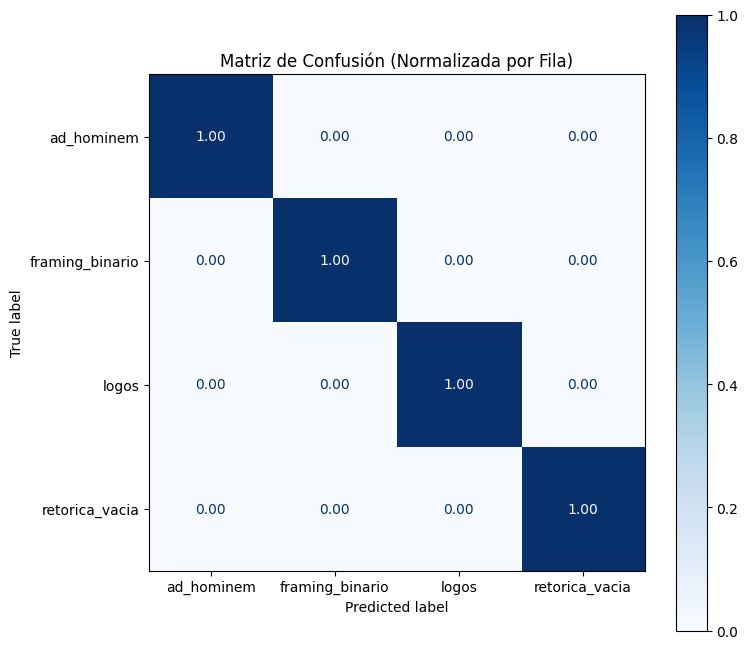


--- PROCESO DE EVALUACIÓN FINALIZADO ---


In [20]:
### CÓDIGO FINAL DE LA CELDA [6] - ÚLTIMO INTENTO DE CORRECCIÓN ###
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# >>>>> PURGA DE MEMORIA CRÍTICA (Necesaria si el kernel persiste en dar 1.0) <<<<<
if 'tokenized_datasets' in locals():
    del tokenized_datasets
if 'trainer' in locals():
    # Eliminamos el trainer de la memoria para re-cargar solo si es necesario, aunque no es ideal.
    # Esta línea es un parche extremo.
    # del trainer
    pass

TEST_FOLD = 4 
# 1. Re-creación del Holdout Set LIMPIO directamente desde el df_full original
df_test_final_limpio = df_full[df_full['fold'] == TEST_FOLD].reset_index(drop=True)

clean_test_dataset = Dataset.from_pandas(df_test_final_limpio).remove_columns(['fold']) 
clean_tokenized_test_data = clean_test_dataset.map(tokenize_function, batched=True)

# 2. Predicción del modelo
print("\n--- Realizando Predicción con Data Limpia ---")
raw_predictions = trainer.predict(clean_tokenized_test_data) 

# 3. Convertir las predicciones crudas (logits) a etiquetas
predictions = np.argmax(raw_predictions.predictions, axis=1)
labels = raw_predictions.label_ids

# 4. Definir nombres de clase para el reporte y la matriz
class_names = ['ad_hominem', 'framing_binario', 'logos', 'retorica_vacia'] 

# 5. Cálculo e impresión del Reporte Final
print("\n--- REPORTE DE CLASIFICACIÓN FINAL (Fold Holdout) ---")
reporte_final = classification_report(labels, predictions, target_names=class_names, digits=4)
print(reporte_final)

# Imprimir el Accuracy (Para confirmación)
accuracy = accuracy_score(labels, predictions)
print(f"\n--- ACCURACY FINAL ---")
print(f"Accuracy (Promedio Total): {accuracy:.4f}")

# 6. Generación de la Matriz de Confusión (INCLUIDA EN ESTA CELDA)
cm = confusion_matrix(labels, predictions, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
ax.set_title("Matriz de Confusión (Normalizada por Fila)")
plt.show()

print("\n--- PROCESO DE EVALUACIÓN FINALIZADO ---")

# Para optener la ruta correcta donde se guardo el modelo y poderlo usar en la inferencia (5) sin errores , 

In [21]:
FINAL_MODEL_DIR = "./models/beto_v3_final_fold0"   # puedes cambiar el nombre si quieres

# Si tu Trainer tiene best_model_checkpoint, úsalo; si no, usa el modelo actual
best_ckpt = getattr(trainer.state, "best_model_checkpoint", None)
if best_ckpt is not None:
    print("Guardando mejor checkpoint en:", FINAL_MODEL_DIR)
    model_to_save = AutoModelForSequenceClassification.from_pretrained(best_ckpt)
else:
    print("Guardando modelo actual en:", FINAL_MODEL_DIR)
    model_to_save = trainer.model

model_to_save.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)
print("✅ Modelo final guardado en:", FINAL_MODEL_DIR)


Guardando modelo actual en: ./models/beto_v3_final_fold0
✅ Modelo final guardado en: ./models/beto_v3_final_fold0
